# Regression

preliminary operations

In [1]:
# from google.colab import files # in order to be able to download and upload files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.model_selection import train_test_split, KFold

import os
from tqdm.notebook import tqdm

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")

Training device: cuda: GeForce GTX 960M


## Datasets

In [4]:
# get the datasets

!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv

all_train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

--2021-01-09 10:54:22--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Risoluzione di gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connessione a gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 3776 (3,7K) [text/plain]
Salvataggio in: "regression_dataset/train_data.csv.4"

train_data.csv.4    100%[===================>]   3,69K  --.-KB/s    in 0,001s  

2021-01-09 10:54:23 (3,75 MB/s) - "regression_dataset/train_data.csv.4" salvato [3776/3776]

--2021-01-09 10:54:23--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Risoluzione di gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connessione a gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza:

In [5]:
class CsvDataset(Dataset):

  def __init__(self, data_df, transform=None):
    '''
    Args:
      data_df: pd.DataFrame object with the data
      transform (callable, optional): Optional transform to be applied on a sample.
    '''
    self.transform = transform
    self.data = data_df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    sample = (row.input, row.label)

    if self.transform:
      sample = self.transform(sample)
    return sample

class ArrayDataset(Dataset):
  '''
  Args:
    data_array: np.array with the data with shape (n_data, 2)
    transform (callable, optional): Optional transform to be applied on a sample.
  '''
  def __init__(self, data_array, transform=None):
    self.transform = transform
    self.data = data_array

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = (self.data[idx,0], self.data[idx,1])
    if self.transform:
      sample = self.transform(sample)
    return sample


class ToTensor(object):
    '''
    Convert sample to Tensors.
    '''
    def __call__(self, sample):
      x,y = sample
      return (torch.tensor([x]).float(), torch.tensor([y]).float())

In [6]:
composed_transform = transforms.Compose([ToTensor()])

all_train_dataset = CsvDataset(all_train_df, transform=composed_transform)
test_dataset   = CsvDataset(test_df, transform=composed_transform)

## Basic solution

### Network definition

In [7]:
class Net(nn.Module):
  def __init__(self, Ni=1, Nh1=None, Nh2=None, No=1, activation_function=nn.Sigmoid(), verbose=False):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()
    self.No = No

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=self.No)

    self.act = activation_function

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)

    return x

In [8]:
class Evolver(object):
  '''
  Class for evolving the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    net
    optimizer: needs to be already linked to the net
    loss_function
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, net, optimizer, loss_function, train_dataloader, val_dataloader):
    self.net = net
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []


  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self):
    train_loss= []
    self.net.train() # Training mode
    for sample_batched in self.train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # set previous gradients to 0
      self.optimizer.zero_grad()
      # Forward pass
      out = self.net(x_batch)
      # Compute loss
      loss = self.loss_function(out,label_batch)
      # Backpropagation
      loss.backward()
      # Update the weights
      self.optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss

  def val_epoch(self,dl):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    self.net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in dl:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      return val_loss

  def evolve(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(range(num_epochs)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss = self.train_epoch()
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      ### VALIDATION
      val_loss = self.val_epoch(self.val_dataloader)
      if verbose:
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      self.val_loss_log.append(val_loss)

      if self.stop_learning(epoch_num):
        break
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

  def plot(self,train_df=None,val_df=None,test_df=None, xmin=-5,xmax=5, n_fine_points=1000):
    '''
    Plots data and the model output

    Args:
      train_df: optional, pd.DataFrame with the training data
      val_df: optional, pd.DataFrame with the validation data
      test_df: optional, pd.DataFrame with the test data
      xmin: minimum value for the input, default -5
      xmax: maximum value for the input, default 5
      n_fine_points: number of points in which to evaluate the model
    '''
    x_vec = torch.linspace(xmin,xmax,n_fine_points).to(device)
    x_vec = x_vec.unsqueeze(-1)

    self.net.eval()
    with torch.no_grad():
      y_vec = self.net(x_vec)

    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(x_vec, y_vec, label='Network output')
    if train_df is not None:
      plt.scatter(train_df.input,train_df.label,label='Training points', color='blue')
    if val_df is not None:
      plt.scatter(val_df.input,val_df.label,label='Validation points', color='orange')
    if test_df is not None:
      plt.scatter(test_df.input,test_df.label,label='Test points', color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()

    return fig, ax

### Setting all hyperparameters

In [ ]:
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

torch.manual_seed(0)

net = Net(Nh1=Nh1, Nh2=Nh2, activation_function=activation_function).to(device)

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0)

loss_function = nn.MSELoss()

val_perc = 0.1
train_batch_size = 10

train_df, val_df = train_test_split(all_train_df,test_size=val_perc,shuffle=True)
train_dataloader = DataLoader(CsvDataset(train_df,transform=composed_transform), batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(CsvDataset(val_df,transform=composed_transform), batch_size=len(val_df), shuffle=False, num_workers=0)


nature = Evolver(net=net,optimizer=optimizer,loss_function=loss_function,train_dataloader=train_dataloader,val_dataloader=val_dataloader)

In [ ]:
nature.evolve(2000,verbose= False)

### Plots

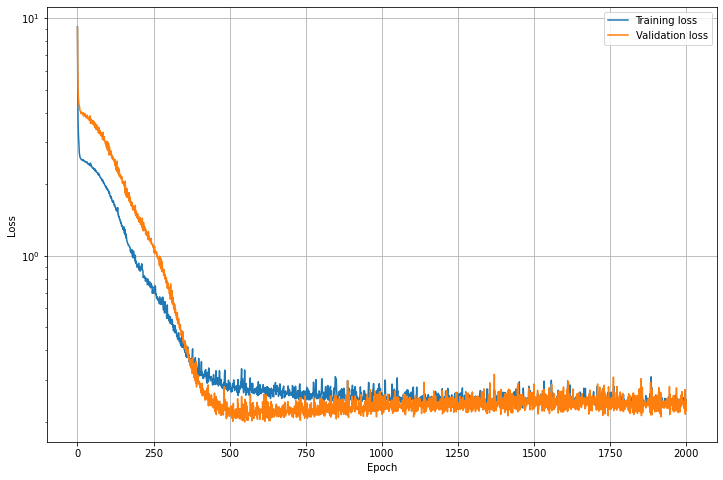

Average traininig  loss in the last 10 epochs: 0.2418
Average validation loss in the last 10 epochs: 0.2375


In [ ]:
nature.plot_losses()

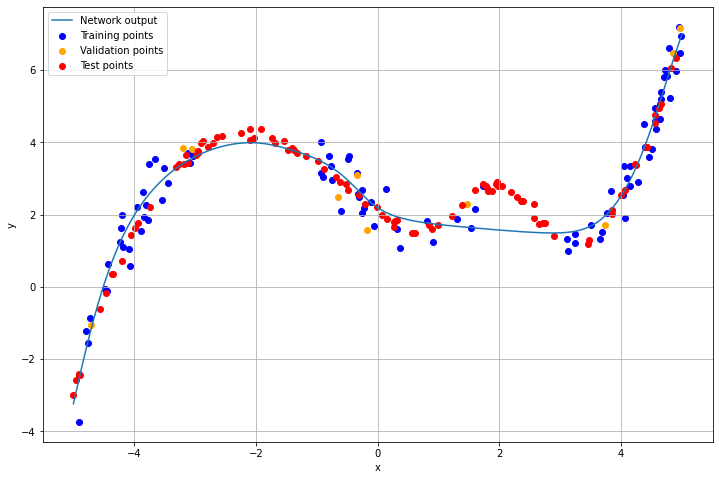

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

In [ ]:
nature.plot(train_df,val_df,test_df)

In [ ]:
test_loss = nature.test(test_dataset)
print(f'Average test loss: {test_loss}')

Average test loss: 0.34173697233200073


## More advanced methods

### K Fold cross validation

#### Implementing K Fold

In [9]:
class KFoldCrossValidator(object):
  '''
  Performs a k fold cross validation on a specific set of hyperparameters

  Args:
    k: int, number of folds
    n_runs: int or None: if n_runs < k, only the first n_runs will be performed.
            This is a quick workaround to speed up the hyperparameter optimization process
    shuffle: bool: if true data is shuffled before the splitting in k folds
    all_train_dataset: Dataset with train and validation data that will be split in folds

    net_type: user defined class
    net_params: dictionary or list of the arguments for net_type.__init__

    optimizer_type: e.g. optim.Adam
    optimizer_params: dictionary or list of the arguments of the optimizer (except net.parameters())

    loss_function
    train_batch_size: int, default 256

    evolver_type: e.g. Evolver or Evolver_es
    evolver_additional_params: dictionary with additional parameters for the evolver,
      e.g. if evolver_type = Evolver_es, the additional parameter 'patience' must be provided
  '''

  def __init__(self, k, n_runs=None, shuffle=False, all_train_dataset=None, net_type=None, net_params=None,
               optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size=256, evolver_type=None, evolver_additional_params={}):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_dataset = all_train_dataset

    self.net_type = net_type
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.train_batch_size = train_batch_size

    self.loss_function = loss_function

    self.evolver_type = evolver_type
    self.evolver_additional_params = evolver_additional_params

    self.evolvers = []

    # set up the object with k (or n_runs) evolvers
    i = 0
    for train_idx, val_idx in self.splitter.split(list(range(len(self.all_train_dataset)))):
      # datasets
      train_dataset = Subset(self.all_train_dataset, train_idx)
      val_dataset = Subset(self.all_train_dataset, val_idx)

      # dataloaders
      train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
      val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

      # net
      if type(self.net_params) == dict:
        net = self.net_type(**self.net_params)
      else:
        net = self.net_type(*self.net_params)

      # optimizer
      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(net.parameters(),**self.optimizer_params)
      else:
        optimizer = self.optimizer_type(net.parameters(),*self.optimizer_params)

      # evolver
      evolver = self.evolver_type(net=net,optimizer=optimizer,loss_function=loss_function,
                                  train_dataloader=train_dataloader,val_dataloader=val_dataloader, **self.evolver_additional_params)

      self.evolvers.append(evolver)

      i += 1
      if n_runs is not None and i >= n_runs:
        break


  def run(self,num_epochs,loss_sample_size=10, prune_thr=None):
    '''
    Args:
      num_epochs: maximum number of epochs for each fold
      loss_sample_size: number of epochs for computing the average train and val losses, default 10
      prune_thr: folat or None: if one of the final validation losses is > prune thr, the run is interrupted raising a ValueError
    '''
    for k,evolver in enumerate(self.evolvers):
      # move the net to the GPU
      evolver.net.to(device)
      evolver.evolve(num_epochs)
      # move the net back to free the GPU
      evolver.net.cpu()
      if prune_thr is not None and k < len(self.evolvers)/2 and evolver.val_loss_log[-1] > prune_thr:
        print(f'Trial pruned: val loss was {evolver.val_loss_log[-1]}')
        raise ValueError


      # print avg train and val loss
      print(np.mean(evolver.train_loss_log[-loss_sample_size:]), np.mean(evolver.val_loss_log[-loss_sample_size:]))

    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.evolvers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.evolvers])
    
    return avg_train_loss, avg_val_loss
    

  def view(self,idx, df=all_train_df):
    '''
    Plot losses and net output
    Args:
      idx: int in [0, k) or 'best', index of the evolver to view
      df: pd.DataFrame with data to plot, default all_train_df
    '''
    if idx == 'best':
      idx = np.argmin([e.best_vl for e in self.evolvers])
      print(f'Best evolver is number {idx} with minimum validation loss {self.evolvers[idx].best_vl}')

    self.evolvers[idx].plot_losses()
    self.evolvers[idx].net.to(device)
    self.evolvers[idx].plot(df)
    self.evolvers[idx].net.cpu()

#### Testing

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver
evolver_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(1000)

In [ ]:
kf.view(4)

### Early stopping

To prevent overfitting and thus speeding up the process

In [10]:
class Evolver_es(Evolver):

  def __init__(self, patience, checkpoint=False, *args, **kwargs):
    '''
    Args:
      patience: int: if after patience peochs the validation loss does not decrease learning stops
      checkpoint: bool: if True when learning stops the net is checkpointed back to when the validation loss was at its minimum

      *args, **kwargs: arguments of the parent class
    '''
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = 10
    self.checkpoint = checkpoint
    self.net_checkpoint = None
    self.optim_checkpoint = None

  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter = 0
      if self.checkpoint:
        self.net_checkpoint = (epoch_num, self.net.state_dict())
        self.optim_checkpoint = self.optimizer.state_dict()
    else:
      self.counter += 1

    if self.counter >= self.patience:
      if self.checkpoint:
        print(f'Checkpointing back to epoch {self.net_checkpoint[0]}')
        self.net.load_state_dict(self.net_checkpoint[1])
        self.optimizer.load_state_dict(self.optim_checkpoint)
        self.train_loss_log = self.train_loss_log[:self.net_checkpoint[0] + 1]
        self.val_loss_log = self.val_loss_log[:self.net_checkpoint[0] + 1]
      return True
    return False

In [ ]:
# testing
k = 5

# net params
net_type = Net
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 20

evolver_type = Evolver_es
evolver_additional_params = {'patience': 100, 'checkpoint': True}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view('best')

### Momentum

In [ ]:
# testing
k = 5

net_type = Net3
net_params = {'Nh1': 128, 'Nh2': 128, 'Nh3': 64, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.SGD
optimizer_params = {'lr': 0.001, 'momentum': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view(1)

### Weight decay

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.01}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(2000)

In [ ]:
kf.view(4)

### Dropout

In [11]:
class Net_d(Net):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, **kwargs):
    '''
    Network with 2 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)
    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)

    if verbose:
      print('Network initialized')
    
  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net_d
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU(),
              'dropout_prob_1': 0.3, 'dropout_prob_2': 0.3}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = [0.001] # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view(4)

### Trying a deeper net

In [12]:
class Net3(Net):
  def __init__(self, Nh3, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    Nh2 = kwargs.get('Nh2')
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
    self.out = nn.Linear(in_features=Nh3,out_features=self.No)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net3
net_params = {'Nh1': 128, 'Nh2': 20, 'Nh3': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.0001} # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 20}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view(4)

In [13]:
class Net3_d(Net3):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, dropout_prob_3=0, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)
    self.d3 = nn.Dropout(dropout_prob_3)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.act(self.fc3(x))
    x = self.d3(x)
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net3_d
net_params = {'Nh1': 128, 'Nh2': 128, 'Nh3': 64, 'activation_function': nn.ReLU(),
              'dropout_prob_1': 0.3, 'dropout_prob_2': 0.4, 'dropout_prob_3': 0}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.0001} # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 200}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view('best')

In [14]:
class Net4(Net3):
  def __init__(self, Nh4, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    Nh3 = kwargs.get('Nh3')
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.fc4 = nn.Linear(in_features=Nh3, out_features=Nh4)
    self.out = nn.Linear(in_features=Nh4,out_features=self.No)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.act(self.fc4(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net4
net_params = {'Nh1': 8, 'Nh2': 64, 'Nh3': 128, 'Nh4': 16, 'activation_function': nn.Tanh()}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.0001}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

In [ ]:
kf.view('best')

In [15]:
class Net4_d(Net4):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, dropout_prob_3=0, dropout_prob_4=0, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)
    self.d3 = nn.Dropout(dropout_prob_3)
    self.d4 = nn.Dropout(dropout_prob_4)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.act(self.fc3(x))
    x = self.d3(x)
    x = self.act(self.fc4(x))
    x = self.d4(x)
    x = self.out(x)

    return x

## Optimizing the hyperparameters

In [ ]:
# possible hyperparams

Nh1s = Nh2s = Nh3s = Nh4s = [8, 16, 32, 64, 128, 256]
dropout_probabilities = [0, 0.15, 0.35, 0.5]
activation_functions = [nn.Tanh(), nn.ReLU()]

optimizer_type = optim.Adam
lrs = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
weight_decays = [0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

train_batch_sizes = [20, 30, 40, 50]

patiences = [100, 200, 300, 400]

### Random search

In [ ]:
df_name = 'regression/random_search5.csv'

if os.path.exists(df_name):
  print('loading existing file')
  df = pd.read_csv(df_name)
else:
  df = None

In [ ]:
iterations = 100

k = 5
prune_thr = 0.4

for i in range(iterations):

  # choose hyperparams
  net_type = Net4_d

  Nh1 = np.random.choice(Nh1s)
  Nh2 = np.random.choice(Nh2s)
  Nh3 = np.random.choice(Nh3s)
  Nh4 = np.random.choice(Nh4s)
  dp1 = 0
  dp2 = np.random.choice(dropout_probabilities)
  dp3 = np.random.choice(dropout_probabilities)
  dp4 = 0
  activation_function = np.random.choice(activation_functions)

  net_params = {'Nh1': Nh1, 'Nh2': Nh2, 'Nh3': Nh3, 'Nh4': Nh4, 'activation_function': activation_function,
                'dropout_prob_1': dp1, 'dropout_prob_2': dp2, 'dropout_prob_3': dp3, 'dropout_prob_4': dp4}

  optimizer_type = optim.Adam
  lr = np.random.choice(lrs)
  weight_decay = np.random.choice(weight_decays)
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}

  loss_function = nn.MSELoss()

  train_batch_size = int(np.random.choice(train_batch_sizes))

  evolver_type = Evolver_es
  patience = np.random.choice(patiences)
  evolver_additional_params = {'patience': patience, 'checkpoint': True}

  hyper_dict = {**net_params, **optimizer_params, 'train_batch_size': train_batch_size, 'patience': patience}

  print(f'Iteration {i}: testing {hyper_dict}')
  
  # K fold
  kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

  try:
    start_time = time.time()
    avg_train_loss, avg_val_loss = kf.run(10000,loss_sample_size=1,prune_thr=prune_thr)
    r_dict = {'avg_train_loss': avg_train_loss, 'avg_val_loss': avg_val_loss, 'train_time': (time.time() - start_time)/60/len(kf.evolvers)}
    print(f'Results: {r_dict}')

    all_dict = {**hyper_dict, **r_dict}

    if df is None:
      print('creating new study')
      df = pd.DataFrame(columns=all_dict.keys())
    if list(df.columns) != list(all_dict.keys()):
      raise KeyError('Keys do not match with existing dataframe')

    df.loc[len(df)] = all_dict
    df.to_csv(df_name,index=False)

    kf.view('best')

  except ValueError:
    print('Trial pruned\n')

In [53]:
df

,Nh1,Nh2,Nh3,Nh4,activation_function,dropout_prob_1,dropout_prob_2,dropout_prob_3,dropout_prob_4,lr,weight_decay,train_batch_size,patience,avg_train_loss,avg_val_loss,train_time
0,8,64,64,16,ReLU(),0,0.00,0.15,0,0.0010,0.00050,30,300,0.335943,0.349150,0.537506
1,128,256,32,64,ReLU(),0,0.15,0.15,0,0.0005,0.00005,30,400,0.390341,0.493564,0.525872
2,32,128,256,64,ReLU(),0,0.15,0.00,0,0.0500,0.00050,40,200,0.595791,0.623703,0.241781
3,128,16,16,256,Tanh(),0,0.35,0.00,0,0.0005,0.00005,40,300,0.607161,0.536282,0.412491
4,64,256,256,128,Tanh(),0,0.00,0.50,0,0.0010,0.00050,40,300,0.283969,0.363221,0.395097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,32,32,128,8,ReLU(),0,0.00,0.00,0,0.0005,0.00001,50,400,0.226824,0.280286,0.855662
61,64,256,64,8,Tanh(),0,0.50,0.00,0,0.0010,0.00010,30,300,0.290857,0.275380,0.774784
62,16,8,256,16,ReLU(),0,0.00,0.35,0,0.0001,0.00100,20,100,0.718705,0.534942,0.969607
63,64,128,128,32,ReLU(),0,0.35,0.35,0,0.0005,0.00000,30,100,0.488291,0.304744,0.252478


#### Analyzing the results

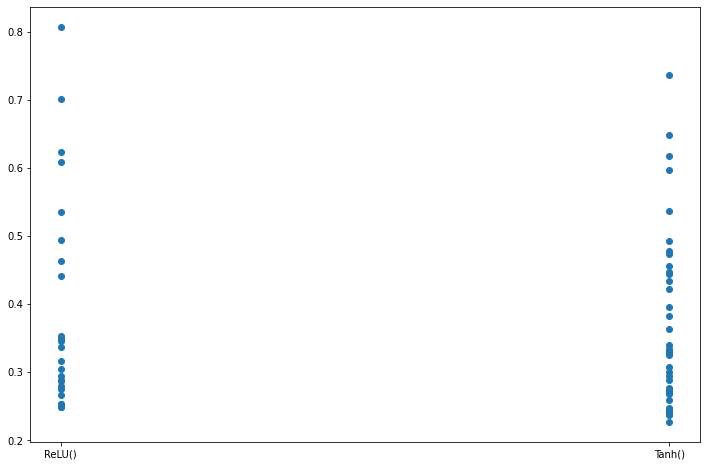

In [56]:
plt.figure(figsize=(12,8))
plt.scatter([str(a) for a in df.activation_function],df.avg_val_loss)

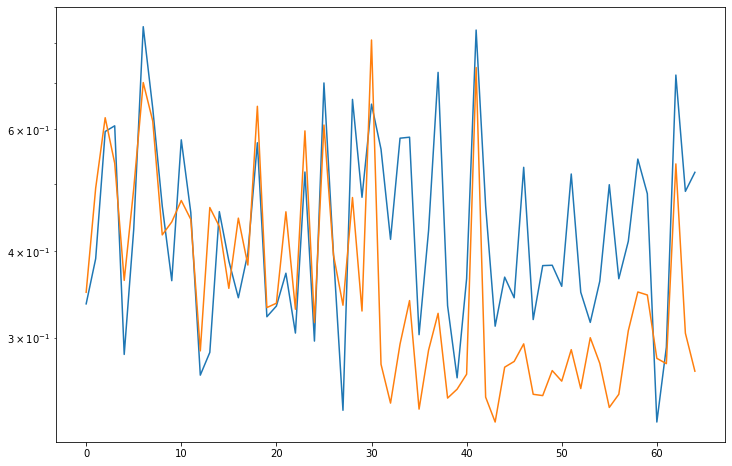

In [57]:
plt.figure(figsize=(12,8))
plt.semilogy(df.avg_train_loss)
plt.semilogy(df.avg_val_loss)

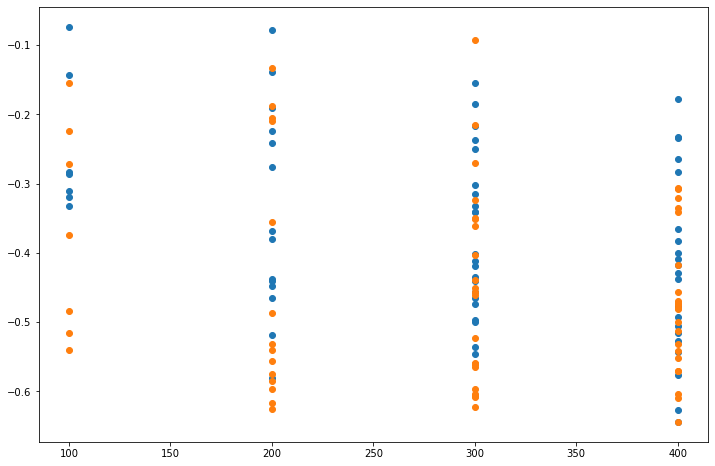

In [58]:
x = df.patience


plt.figure(figsize=(12,8))
plt.scatter(x, np.log10(df.avg_train_loss))
plt.scatter(x, np.log10(df.avg_val_loss))

In [59]:
best_idx = np.argmin(df.avg_val_loss)
print(best_idx)
df.loc[best_idx]

43


Nh1                          32
Nh2                         128
Nh3                          64
Nh4                         256
activation_function      Tanh()
dropout_prob_1                0
dropout_prob_2              0.5
dropout_prob_3                0
dropout_prob_4                0
lr                        0.001
weight_decay                  0
train_batch_size             30
patience                    400
avg_train_loss          0.31191
avg_val_loss           0.226818
train_time             0.864847
Name: 43, dtype: object

## Final test

### Train the net with optimal hyperparameters

In [36]:
k = 5

# net params
net_type = Net4_d
net_params = {'Nh1': 32, 'Nh2': 128, 'Nh3': 64, 'Nh4': 256, 'activation_function': nn.Tanh(),
                'dropout_prob_1': 0, 'dropout_prob_2': 0.5, 'dropout_prob_3': 0, 'dropout_prob_4': 0}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.0}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = {'patience': 400, 'checkpoint': True}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

avg_train_loss, avg_val_loss = kf.run(10000, loss_sample_size=1)

Checkpointing back to epoch 446

0.4050548 0.26508


Checkpointing back to epoch 1200

0.2818145 0.15597212


Checkpointing back to epoch 687

0.317554 0.2998941


Checkpointing back to epoch 479

0.33551145 0.278896


Checkpointing back to epoch 453

0.29256296 0.21773462


Best evolver is number 1 with minimum validation loss 0.15597212314605713


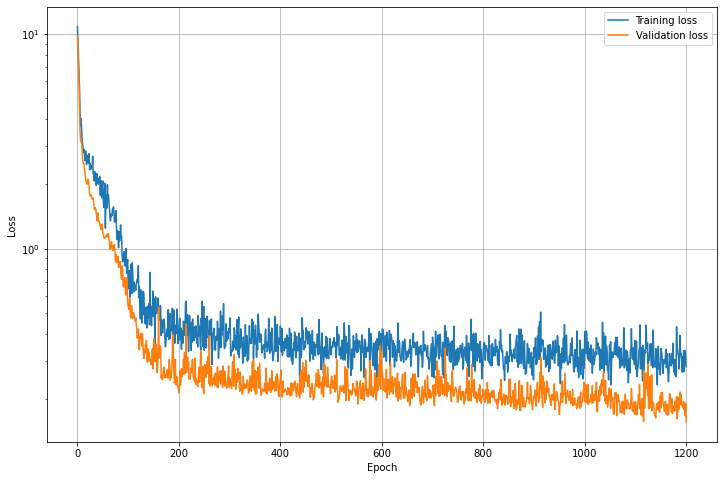

Average traininig  loss in the last 10 epochs: 0.3008
Average validation loss in the last 10 epochs: 0.1822


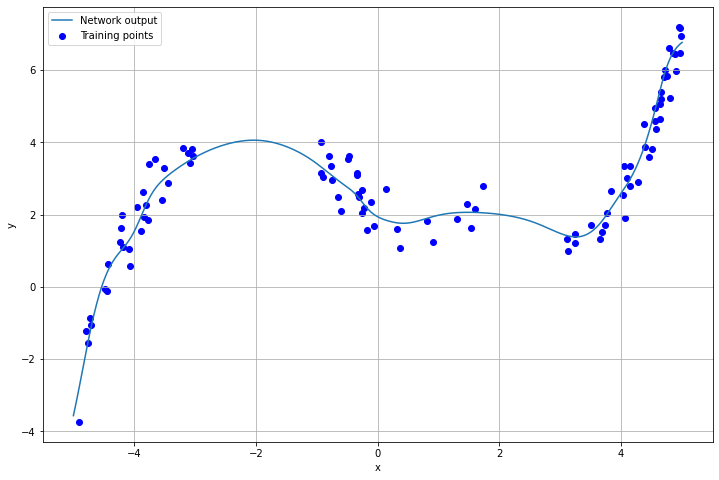

In [37]:
kf.view('best')

In [38]:
# select best net

print([ev.val_loss_log[-1] for ev in kf.evolvers])
idx = np.argmin([ev.val_loss_log[-1] for ev in kf.evolvers])
print(idx)

[0.26508, 0.15597212, 0.2998941, 0.278896, 0.21773462]
1


### Test the best net

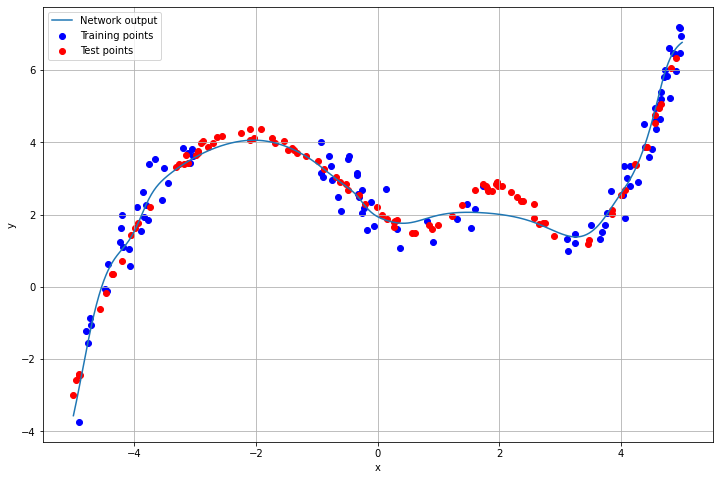

Net4_d(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=128, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Tanh()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=256, bias=True)
  (d1): Dropout(p=0, inplace=False)
  (d2): Dropout(p=0.5, inplace=False)
  (d3): Dropout(p=0, inplace=False)
  (d4): Dropout(p=0, inplace=False)
)

In [50]:
kf.evolvers[idx].net.to(device)
kf.evolvers[idx].plot(train_df=all_train_df,test_df=test_df)
kf.evolvers[idx].net.cpu()

In [60]:
kf.evolvers[idx].net.to(device)
test_loss = kf.evolvers[idx].test(test_dataset)
kf.evolvers[idx].net.cpu()
print(f'Test loss = {test_loss}')

Test loss = 0.12162737548351288


In [41]:
# save best net
torch.save(kf.evolvers[idx].net.state_dict(), 'regression/best_net3.pth')
torch.save(kf.evolvers[idx].optimizer.state_dict(), 'regression/best_net_optim3.pth')

## Visualization of the net

In [42]:
best_net_params = {'Nh1': 32, 'Nh2': 128, 'Nh3': 64, 'Nh4': 256, 'activation_function': nn.Tanh(),
                'dropout_prob_1': 0, 'dropout_prob_2': 0.5, 'dropout_prob_3': 0, 'dropout_prob_4': 0}

best_net = Net4_d(**best_net_params)
best_net_state_dict = torch.load('regression/best_net3.pth')
best_net.load_state_dict(best_net_state_dict)

<All keys matched successfully>

### Weights

In [43]:
h1_w = best_net.fc1.weight.data.cpu().numpy()
h2_w = best_net.fc2.weight.data.cpu().numpy()
h3_w = best_net.fc3.weight.data.cpu().numpy()
h4_w = best_net.fc4.weight.data.cpu().numpy()
out_w = best_net.out.weight.data.cpu().numpy()

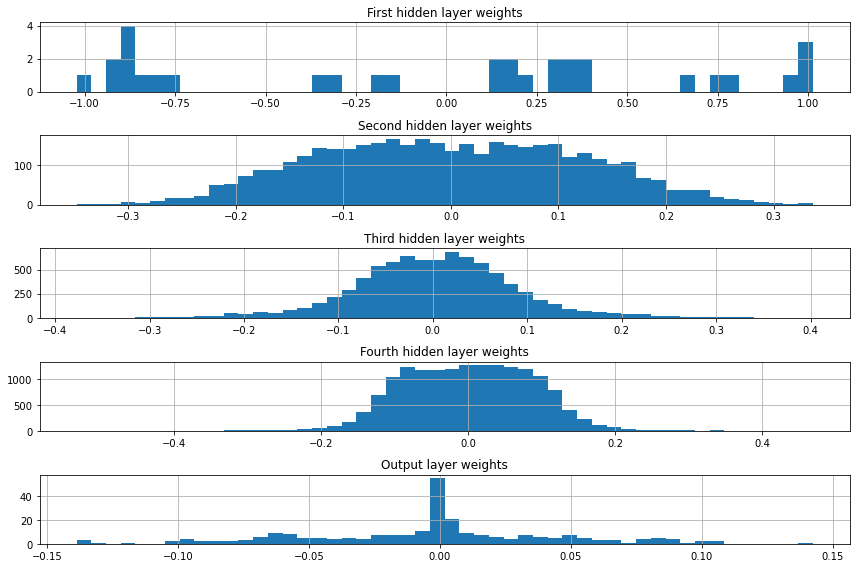

In [44]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('Fourth hidden layer weights')
axs[4].hist(out_w.flatten(), 50)
axs[4].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

It makes sense that most of the weights are near 0 since the net was trained with L2 penalty on the weights

### Activation profile

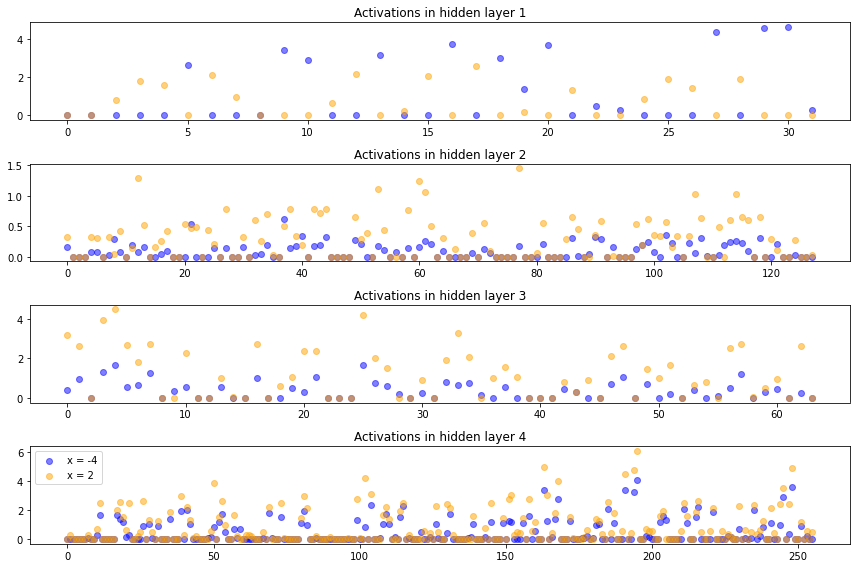

In [52]:
x1 = -4
x2 = 2

#define a hook for each layer

def get_activation1(layer, input, output):
    global activation1 # define global variable in which to store the activations.
    activation1 = torch.relu(output)

hook_handle1 = best_net.fc1.register_forward_hook(get_activation1)

def get_activation2(layer, input, output):
    global activation2 # define global variable in which to store the activations.
    activation2 = torch.relu(output)

hook_handle2 = best_net.fc2.register_forward_hook(get_activation2)

def get_activation3(layer, input, output):
    global activation3 # define global variable in which to store the activations.
    activation3 = torch.relu(output)

hook_handle3 = best_net.fc3.register_forward_hook(get_activation3)

def get_activation4(layer, input, output):
    global activation4 # define global variable in which to store the activations.
    activation4 = torch.relu(output)

hook_handle4 = best_net.fc4.register_forward_hook(get_activation4)

# evaluate the net
best_net = best_net.to(device)
best_net.eval()
with torch.no_grad():
    x = torch.tensor([x1]).float().to(device)
    y = best_net(x)
    a1 = activation1.cpu().numpy()
    a2 = activation2.cpu().numpy()
    a3 = activation3.cpu().numpy()
    a4 = activation4.cpu().numpy()

    x = torch.tensor([x2]).float().to(device)
    y = best_net(x)
    a1b = activation1.cpu().numpy()
    a2b = activation2.cpu().numpy()
    a3b = activation3.cpu().numpy()
    a4b = activation4.cpu().numpy()

a_s = [a1,a2,a3,a4]
ab_s = [a1b,a2b,a3b,a4b]

# remove hooks
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()
hook_handle4.remove()

#plot activations
fig, axs = plt.subplots(4,1, figsize=(12,8))
for i,a in enumerate(a_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x1}',color='blue', alpha=0.5)
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

for i,a in enumerate(ab_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x2}',color='orange', alpha=0.5)
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

plt.legend()

fig.tight_layout()